In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

In [4]:
# Load datasets
train_df = pd.read_csv("Titanic_train.csv")
test_df = pd.read_csv("Titanic_test.csv")

In [6]:
# Checking for missing values
print("Training set missing values:\n", train_df.isnull().sum())
print("Test set missing values:\n", test_df.isnull().sum())

Training set missing values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Test set missing values:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


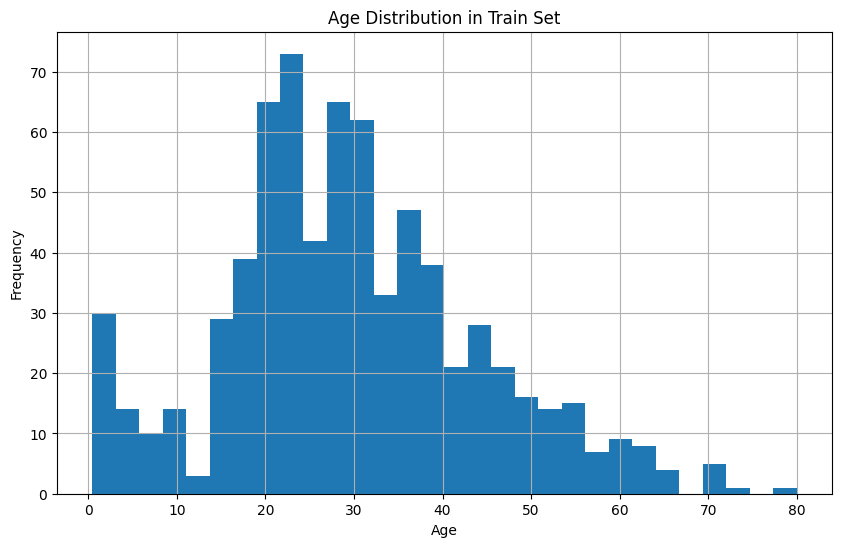

In [8]:
# Visualize Age distribution
plt.figure(figsize=(10, 6))
train_df['Age'].hist(bins=30)
plt.title("Age Distribution in Train Set")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

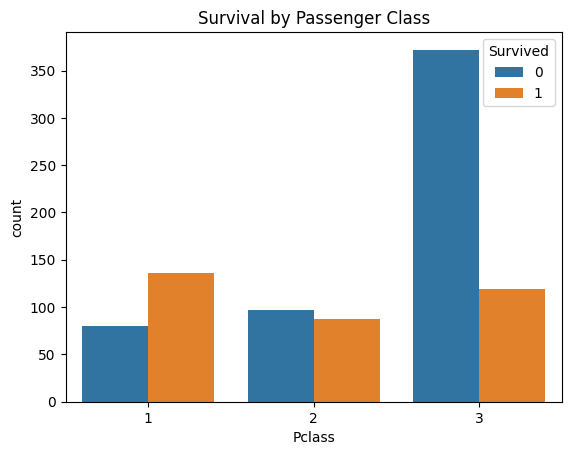

In [10]:
# Relationship between Pclass and survival
sns.countplot(x='Pclass', hue='Survived', data=train_df)
plt.title("Survival by Passenger Class")
plt.show()

In [32]:
# Impute missing values
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].median())
test_df['Age'] = test_df['Age'].fillna(test_df['Age'].median())
train_df['Embarked'] = train_df['Embarked'].fillna(train_df['Embarked'].mode()[0])
test_df['Fare'] = test_df['Fare'].fillna(test_df['Fare'].median())

# Drop 'Cabin' column due to high missing values
train_df = train_df.drop(columns=['Cabin'])
test_df = test_df.drop(columns=['Cabin'])

KeyError: "['Cabin'] not found in axis"

In [14]:
# Encoding categorical variables
for col in ['Sex', 'Embarked']:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.transform(test_df[col])

In [16]:
# Feature and Target Selection
X = train_df.drop(columns=['Survived', 'PassengerId', 'Name', 'Ticket'])
y = train_df['Survived']
X_test = test_df.drop(columns=['PassengerId', 'Name', 'Ticket'])

# Split the training data for evaluation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Initialize LightGBM and XGBoost
lgbm = lgb.LGBMClassifier()
xgbm = xgb.XGBClassifier(eval_metric='logloss')

# Train LightGBM
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_val)

# Train XGBoost
xgbm.fit(X_train, y_train)
y_pred_xgbm = xgbm.predict(X_val)

[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 194
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [20]:
# Define evaluation function
def evaluate_model(y_true, y_pred, model_name):
    print(f"{model_name} Performance:")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print("-" * 30)

In [22]:
# Evaluate LightGBM and XGBoost models
evaluate_model(y_val, y_pred_lgbm, "LightGBM")
evaluate_model(y_val, y_pred_xgbm, "XGBoost")

LightGBM Performance:
Accuracy: 0.8212290502793296
Precision: 0.7837837837837838
Recall: 0.7837837837837838
F1 Score: 0.7837837837837838
------------------------------
XGBoost Performance:
Accuracy: 0.7877094972067039
Precision: 0.7368421052631579
Recall: 0.7567567567567568
F1 Score: 0.7466666666666667
------------------------------


In [24]:
# Hyperparameter Tuning for LightGBM
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300]
}

# Using GridSearchCV for tuning LightGBM
grid_lgbm = GridSearchCV(lgb.LGBMClassifier(), param_grid, cv=5, scoring='accuracy')
grid_lgbm.fit(X_train, y_train)
best_lgbm = grid_lgbm.best_estimator_
y_pred_lgbm_tuned = best_lgbm.predict(X_val)

[LightGBM] [Info] Number of positive: 214, number of negative: 355
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 179
[LightGBM] [Info] Number of data points in the train set: 569, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376098 -> initscore=-0.506142
[LightGBM] [Info] Start training from score -0.506142
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [25]:
# Using GridSearchCV for tuning XGBoost
grid_xgbm = GridSearchCV(xgb.XGBClassifier(eval_metric='logloss'), param_grid, cv=5, scoring='accuracy')
grid_xgbm.fit(X_train, y_train)
best_xgbm = grid_xgbm.best_estimator_
y_pred_xgbm_tuned = best_xgbm.predict(X_val)

In [28]:
# Evaluate Tuned Models
evaluate_model(y_val, y_pred_lgbm_tuned, "Tuned LightGBM")
evaluate_model(y_val, y_pred_xgbm_tuned, "Tuned XGBoost")

Tuned LightGBM Performance:
Accuracy: 0.8044692737430168
Precision: 0.7910447761194029
Recall: 0.7162162162162162
F1 Score: 0.75177304964539
------------------------------
Tuned XGBoost Performance:
Accuracy: 0.8212290502793296
Precision: 0.8387096774193549
Recall: 0.7027027027027027
F1 Score: 0.7647058823529411
------------------------------


In [30]:
# Final Prediction on Test Set
final_predictions_lgbm = best_lgbm.predict(X_test)
final_predictions_xgbm = best_xgbm.predict(X_test)

# Print final predictions
print("Final LightGBM predictions on test set:\n", final_predictions_lgbm)
print("Final XGBoost predictions on test set:\n", final_predictions_xgbm)

Final LightGBM predictions on test set:
 [0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 0 1 0 1
 0 0 1 0 1 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 0
 1 1 0 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 1 0 1 0 0 1 0 0 1 0 0 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 1 1 0 1 0 1 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 1 0 1 0 0 0]
Final XGBoost predictions on test set:
 [0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 0 1 0 1 0 1 0 0 0 0 0 1 0 1